In [5]:
# Collect the list of the S&P 500 companies from Wikipedia and save it to a file
import os
import requests
import pandas as pd

# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content
df = pd.read_html(html, header=0)[0]
tickers = df['Symbol'].tolist()

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'APO',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BK',
 'BA',
 'BKNG',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BLDR',
 'BG',
 'BXP',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'COIN',
 'CL',
 'CMCSA',
 'CAG',
 'COP',
 'ED',
 'STZ',
 'CEG',

In [8]:
# Load the data from yahoo finance
import os
import yfinance as yf

def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2023-12-31')

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder.append(df)
        ticker_with_data.append(symbol)

tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')

$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2005-01-01 -> 2023-12-31)
$GEV: possibly delisted; no price data found  (1d 2005-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1104555600, endDate = 1703998800")
$SW: possibly delisted; no price data found  (1d 2005-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1104555600, endDate = 1703998800")
$SOLV: possibly delisted; no price data found  (1d 2005-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1104555600, endDate = 1703998800")


Loaded data for 498 companies


In [9]:
monthly_data = []
for data in holder:
    df = data.resample('M').agg({
        'date': 'first',
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    df.set_index('date', inplace=True)

    monthly_data.append(df)


In [10]:
del holder

In [16]:
import numpy as np
from multiprocessing import Pool

def process_data(df):
    
    df['intra_month_return'] = df['Close'] / df['Open'] - 1
    df['next_month_return'] = df['intra_month_return'].shift(-1)
    
    df['monthly_return'] = df['Close'].pct_change()

    # Last 12 months return except the current month
    df['rolling_12_months_return'] = df['Close'].pct_change().rolling(11).sum().shift()

    return df

monthly_data = [process_data(df) for df in monthly_data]

In [19]:
holder = []
for df in monthly_data:
    holder.append(df[['rolling_12_months_return', 'next_month_return', 'monthly_return']].dropna())
df_for_regression = pd.concat(holder, axis=0, ignore_index=True)

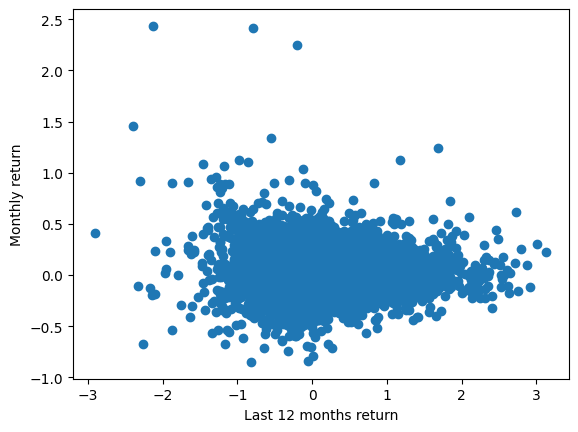

In [22]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.scatter(df_for_regression['rolling_12_months_return'], df_for_regression['next_month_return'])
plt.xlabel('Last 12 months return')
plt.ylabel('Monthly return')
plt.show()

In [26]:
import numpy as np

mask_next_month_return = (np.abs(df_for_regression['next_month_return'] - df_for_regression['next_month_return'].mean()) < 3 * df_for_regression['next_month_return'].std())
mask_rolling_12_months_return = (np.abs(df_for_regression['rolling_12_months_return'] - df_for_regression['rolling_12_months_return'].mean()) < 3 * df_for_regression['rolling_12_months_return'].std())
df_for_regression = df_for_regression[
    mask_next_month_return & mask_rolling_12_months_return
]

In [29]:
X = sm.add_constant(df_for_regression['rolling_12_months_return'])
y = df_for_regression['next_month_return']

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      next_month_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     64.70
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           8.80e-16
Time:                        16:45:30   Log-Likelihood:             1.0797e+05
No. Observations:               94780   AIC:                        -2.159e+05
Df Residuals:                   94778   BIC:                        -2.159e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## Analyze results:

- R-squared: 0.001 means that only 0.1% of the variation of next_month is explained by rolling_12_months
- coef: -0.0081 means that if a stock went up 100% in the last 12 months, the model expects next_month to be -0.81% (negative)
- P>|t|: 0.000. p-value is almost zero -> statistically significant. Not random relationship.

### Conclusions:

Expected output: Momentum - winners keep winning.

Reality: Negative coefficient - winners slightly fall back.

Hypothesis:
1. Testing SP500. Momentum works best in small/mid size stocks (russell 2000)
2. Time period: 2005-2023. Market has changed a lot through the years
3. Momentum doesn't work anymore? only works in extremes (top 10% winners/losers)?
4. Not a linear relationship


In [30]:
rolling_12_months_return_holder = []
next_month_return_holder = []
monthly_return_holder = []

for symbol, df in zip(tickers, monthly_data):
    rolling_12_months_return_series = df['rolling_12_months_return'].copy().dropna()
    next_month_return_series = df['next_month_return'].copy().dropna()
    monthly_return = df['monthly_return'].copy().dropna()

    rolling_12_months_return_series.name = symbol
    next_month_return_series.name = symbol
    monthly_return.name = symbol

    rolling_12_months_return_holder.append(rolling_12_months_return_series)
    next_month_return_holder.append(next_month_return_series)
    monthly_return_holder.append(monthly_return)

In [38]:
rolling_12_months_return_df = pd.concat(rolling_12_months_return_holder, axis=1, ignore_index=False)
rolling_12_months_return_df.fillna(0, inplace=True)
next_month_return_df = pd.concat(next_month_return_holder, axis=1, ignore_index=False)
monthly_return_df = pd.concat(monthly_return_holder, axis=1, ignore_index=False)

print (rolling_12_months_return_df.iloc[:5, :5])
print (next_month_return_df.iloc[:5, :5])
print (monthly_return_df.iloc[:5, :5])

                                MMM       AOS       ABT  ABBV       ACN
date                                                                   
2006-01-03 00:00:00-05:00 -0.051332  0.314975 -0.099370   0.0  0.135572
2006-02-01 00:00:00-05:00 -0.112641  0.577853 -0.019359   0.0  0.246902
2006-03-01 00:00:00-05:00 -0.115545  0.553795 -0.009188   0.0  0.337536
2006-04-03 00:00:00-04:00  0.020589  0.701410 -0.108465   0.0  0.359683
2006-05-01 00:00:00-04:00  0.141421  0.502168 -0.076306   0.0  0.253616
                                MMM       AOS       ABT  ABBV           ACN
date                                                                       
2005-01-03 00:00:00-05:00  0.000137 -0.032401  0.021546   NaN  2.771428e-07
2005-02-01 00:00:00-05:00  0.020726  0.096468  0.013699   NaN -5.590309e-02
2005-03-01 00:00:00-05:00 -0.110814 -0.006883  0.055816   NaN -1.309570e-01
2005-04-01 00:00:00-05:00  0.007851  0.098425 -0.015510   NaN  7.528921e-02
2005-04-14 00:00:00-04:00       NaN     

In [39]:
N = 20
long_df = rolling_12_months_return_df[(rolling_12_months_return_df > 0)]
short_df = rolling_12_months_return_df[(rolling_12_months_return_df < 0)]


In [41]:
long_df = long_df.mask(long_df.rank(axis=1, method='dense', ascending=False) > N, np.nan)
short_df = short_df.mask(short_df.rank(axis=1, method='dense', ascending=True) > N, np.nan)


In [43]:
long_df_symbols = long_df.apply(lambda row: row.dropna().index.tolist(), axis=1)
short_df_symbols = short_df.apply(lambda row: row.dropna().index.tolist(), axis=1)

In [46]:
long_df_symbols

date
2006-01-03 00:00:00-05:00    [AMD, GOOGL, GOOG, AAPL, CME, EOG, HOLX, ISRG,...
2006-02-01 00:00:00-05:00    [AMD, AKAM, GOOGL, GOOG, CME, GLW, CCI, DLR, H...
2006-03-01 00:00:00-05:00    [AMD, AKAM, GOOGL, GOOG, CME, GLW, CCI, DLR, H...
2006-04-03 00:00:00-04:00    [AMD, AKAM, CBRE, CME, DECK, DXCM, HOLX, ISRG,...
2006-05-01 00:00:00-04:00    [AMD, AKAM, CBRE, CME, DECK, FCX, GRMN, HOLX, ...
                                                   ...                        
2023-08-01 00:00:00-04:00    [AVGO, BLDR, CCL, COIN, DHI, FICO, FSLR, GE, J...
2023-09-01 00:00:00-04:00    [ADBE, APO, AMAT, AXON, AVGO, BLDR, CZR, CCL, ...
2023-10-02 00:00:00-04:00    [AMD, ALGN, APO, AVGO, BLDR, CCL, DELL, DASH, ...
2023-11-01 00:00:00-04:00    [ADBE, ANET, AVGO, BLDR, CCL, COIN, CRWD, DECK...
2023-12-01 00:00:00-05:00    [ADBE, AMD, ANET, BLDR, CCL, COIN, CRWD, DELL,...
Length: 216, dtype: object

In [47]:
mask = long_df.notna() | short_df.notna()
rolling_12_months_return_df_for_regression = rolling_12_months_return_df[mask]
next_month_return_df_for_regression = next_month_return_df[mask]

In [48]:
rolling_12_months_return_holder = []
next_month_return_holder = []

for i in range(len(rolling_12_months_return_df_for_regression)):
    rolling_12_months_return_holder.extend(rolling_12_months_return_df_for_regression.iloc[i].tolist())
    next_month_return_holder.extend(next_month_return_df_for_regression.iloc[i].tolist())


In [49]:
rolling_12_months_return_df_for_regression = pd.Series(rolling_12_months_return_holder)
next_month_return_df_for_regression = pd.Series(next_month_return_holder)

rolling_12_months_return_df_for_regression.name = 'rolling_12_months_return'
next_month_return_df_for_regression.name = 'next_month_return'


df_for_regression = pd.concat([rolling_12_months_return_df_for_regression, next_month_return_df_for_regression], axis=1)
df_for_regression = df_for_regression.dropna()

In [51]:
X = sm.add_constant(df_for_regression['rolling_12_months_return'])
y = df_for_regression['next_month_return']

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      next_month_return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.788
Date:                Wed, 16 Jul 2025   Prob (F-statistic):             0.0953
Time:                        17:38:58   Log-Likelihood:                 315.28
No. Observations:                 883   AIC:                            -626.6
Df Residuals:                     881   BIC:                            -617.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## Analyze results:

- R-squared: 0.003. Only 0.3% of the variation in next_month_return is explained by rolling_12_months_return. Still low.
- coef: 0.0137 - If a stock went up 100% over the last 12 months, the model expects it to go up +1.37% next month. Good sign.
- P>|t|: 0.095 - p-value is 9.5%, meaning the coefficient is not statistically significant at the usual 5% level. Bad sign.

### Conclusions:

Coefficient is positive, but weak and not significant. Statistically, it may just be noise.

